In [1]:
# Import libraries
import pandas as pd
from pandas_datareader import data as pdr

import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

import talib, re, ipyparams

from Agent import Agent

C:\Users\Elid-PC.DESKTOP-MG9DS93\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


<IPython.core.display.Javascript object>

Using TensorFlow backend.


In [2]:
end_date = '2020-04-19'
start_date = '2017-04-20'

symbol = 'CSCO'
Date = pd.DataFrame(pdr.DataReader(symbol,'yahoo', start_date, end_date))

alldata = pd.DataFrame({'Date': Date.index})
alldata[symbol] = pdr.DataReader(symbol, 'yahoo', start_date, end_date)['Adj Close'].values
# Stock symbol

# Load close prices of to NumPy array
close = alldata[symbol].values
len(close)

755

In [3]:
close

array([29.76637077, 29.93047714, 29.9213562 , 30.34072876, 30.46836281,
       30.45013046, 30.76921463, 31.06095695, 30.96978569, 31.21593666,
       31.22506142, 31.16123962, 31.35269165, 31.26152611, 30.90597153,
       30.7600975 , 30.65981674, 30.49571609, 31.20682144, 31.27064514,
       30.83302879, 28.60853386, 28.45355034, 28.7999897 , 28.95497513,
       28.70882225, 28.66323662, 28.71793747, 28.88204193, 28.74528885,
       29.00967789, 29.15554428, 28.95497513, 28.77263641, 28.81822395,
       28.81822395, 28.59942055, 28.49001503, 28.90027046, 28.80910683,
       28.79087257, 28.83645821, 29.16466331, 29.03702927, 29.02791023,
       29.03702927, 29.25582886, 29.39258003, 28.95497513, 29.24671364,
       28.63588524, 28.53559875, 28.56295013, 28.62736702, 28.26848793,
       28.4341259 , 28.50774193, 28.60896492, 28.67337418, 28.77459717,
       28.91262627, 28.98624229, 28.99544525, 29.35431862, 29.31751633,
       29.29911232, 29.31751633, 29.5567646 , 29.13347244, 29.05

In [4]:
macd, macdsignal, macdhist = talib.MACD(close, fastperiod=5, slowperiod=20, signalperiod=9)
macdhist = macdhist[~np.isnan(macdhist)]
macd = macd[-len(macdhist):]
macdsignal = macdsignal[-len(macdhist):]


pd.DataFrame({'macd': macd, 'macdsignal': macdsignal, 'macdhist': macdhist}).head()

,macd,macdsignal,macdhist
0,-0.886239,-0.621232,-0.265006
1,-0.792779,-0.655542,-0.137238
2,-0.743800,-0.673193,-0.070606
3,-0.627694,-0.664093,0.036399
4,-0.503005,-0.631876,0.128871


In [5]:
def prepare_dataset(close):
    """
    Function prepare_dataset to generate input data and trading strategy from stock close prices
    """

    macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

    # Cancel NaN values
    macdhist = macdhist[~np.isnan(macdhist)]
    macd = macd[-len(macdhist):]
    macdsignal = macdsignal[-len(macdhist):]

    # Scaling features to a range [0, 1]
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    macdhist_norm = min_max_scaler.fit_transform(np.expand_dims(macdhist, axis=1))

    # Implement strategy
    start_sell = 0.2
    stop_sell = 0.05
    start_buy = -0.2
    stop_buy = -0.05

    y = np.full(len(macdhist), np.nan)
    y[0] = 0

    for i in range(1, len(macdhist)):

        if y[i-1] == 0:
            if (macdhist_norm[i] >= start_sell):
                # Enter sell position
                y[i] = -1
            elif (macdhist_norm[i] <= start_buy):
                # Enter buy position
                y[i] = 1
            else:
                y[i] = 0
        elif y[i-1] == -1:
            if macdhist_norm[i] > stop_sell:
                # Stay in sell position
                y[i] = -1
            else:
                # Leave sell position
                y[i] = 0
        else:
            if macdhist_norm[i] < stop_buy:
                # Stay in buy position
                y[i] = 1
            else:
                # Leave buy position
                y[i] = 0

    # Plot strategy
    dates = np.arange(len(macdhist))
    plt.plot(dates, y,'g', label='Strategy Positions')
    plt.bar(dates, macdhist_norm[:, 0], width=1, color='blue', label='MACD histogram')
    plt.plot(dates, start_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_sell * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, start_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.plot(dates, stop_buy * np.ones(len(macdhist)), 'k--', lw=1)
    plt.xlabel('Days')
    plt.xlim((0, len(y)))
    plt.legend()
    # plt.savefig('images/AAL_macd.png', bbox_inches='tight')
    plt.show()
    
    # Generate input data - technical indicators
    ind1 = talib.MIDPOINT(close)    # Overlap: MidPoint over period
    ind2 = talib.HT_DCPERIOD(close) # Cycle Indicator Functions:  Hilbert Transform - Dominant Cycle Period
    ind3 = talib.MAX(close)         # Math Operator: Highest value over a specified period
    ind4 = talib.SIN(close)         # Math Transform: Vector Trigonometric Sin
    ind5 = talib.APO(close)         # Momentum: Absolute Price Oscillator
    ind6 = talib.TEMA(close, timeperiod=5) ## Triple Exponential Moving Average

    x = np.vstack((macdhist, macd, macdsignal, ind1[-len(macdhist):], ind2[-len(macdhist):],
                   ind3[-len(macdhist):], ind4[-len(macdhist):], ind5[-len(macdhist):],
                   ind6[-len(macdhist):]))
    x = x.T

    return x, y

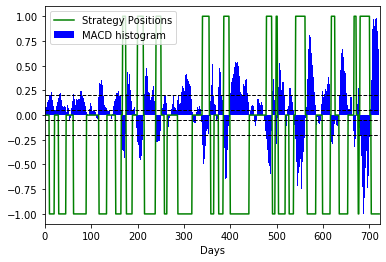

In [6]:
# Implement MACD trading strategy
X, y = prepare_dataset(close)

In [7]:
X[0]

array([-1.21967228e-03, -5.09221588e-01, -5.08001916e-01,  2.96432896e+01,
        1.69405076e+01,  3.13526917e+01, -4.77935180e-01, -1.09506732e+00,
        2.88949841e+01])

In [8]:
# Split dataset
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X[:n_train], y[:n_train]
X_test, y_test = X[n_train:], y[n_train:]

In [9]:
# Normalize data
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Encode trading signal with integers between 0 and n-1 classes
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(le.classes_)

[-1.  0.  1.]


In [11]:
## Create and train the Agent
# Variable definiton
episodes = 20
look_back = 5
batch_size = 32
action_size = len(le.classes_)
n_features = X_train.shape[1]

In [12]:
# Create Agent
agent = Agent(look_back, action_size, n_features)

In [13]:
def run(agent, dataX, dataY, episodes, look_back):
    """
    Function run to train the agent
    """
    
    # Length of dataset
    times = len(dataX)

    # List of total rewards
    total_reward_list = []

    for ep in range(episodes):

        # print('Episode: ' + str(ep))
        
        # Initial state and position
        state = dataX[:look_back, :][np.newaxis, :, :]
        pos = dataY[look_back - 1]

        done = False
        total_reward = 0

        for t in range(1, times - look_back + 1):

            # Predict action based on the current state
            action = agent.act(state)

            # Calculate reward
            if action == pos:   # 0:-1      1:0     2:1
                reward = +1

            elif (pos == 0 or pos == 2):
                if action == 1:
                    reward = 0
                else:
                    reward = -1
            else:
                reward = -1

            total_reward += reward

            # Final state
            if t == times - look_back:
                done = True

            # Receive next state and position
            next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
            next_pos = dataY[t + look_back - 1]
            
            # Remember current experience
            agent.remember(state, action, reward, next_state, done)
            
            # Make next_state the new current state; the same for pos
            state = next_state
            pos = next_pos

            if done:
                print('Episode: %i ---> Total Reward: %i' %(ep, total_reward))
                total_reward_list.append(total_reward)

            # Train the agent with previous experiences
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        if (ep + 1) % 5 == 0 and ep > 0:
            file = 'checkpoints/' + symbol + '_robot_checkpoint' + str(ep + 1)
            # Serialize weights to HDF5
            agent.model.save_weights(file + ".h5")
            # Save epsilon
            pickle.dump(agent.epsilon, open(file + "_epsilon.pickle", "wb"))

    # Save list of rewards along the epochs
    np.savetxt(file + '_total_reward.txt', total_reward_list)

    return


In [14]:
# Train Agent
run(agent, X_train, y_train, episodes, look_back)

Episode: 0 ---> Total Reward: 109
Episode: 1 ---> Total Reward: 316
Episode: 2 ---> Total Reward: 353
Episode: 3 ---> Total Reward: 341
Episode: 4 ---> Total Reward: 388
Episode: 5 ---> Total Reward: 431
Episode: 6 ---> Total Reward: 424
Episode: 7 ---> Total Reward: 430
Episode: 8 ---> Total Reward: 457
Episode: 9 ---> Total Reward: 467
Episode: 10 ---> Total Reward: 459
Episode: 11 ---> Total Reward: 481
Episode: 12 ---> Total Reward: 478
Episode: 13 ---> Total Reward: 464
Episode: 14 ---> Total Reward: 456
Episode: 15 ---> Total Reward: 469
Episode: 16 ---> Total Reward: 450
Episode: 17 ---> Total Reward: 431
Episode: 18 ---> Total Reward: 478
Episode: 19 ---> Total Reward: 505


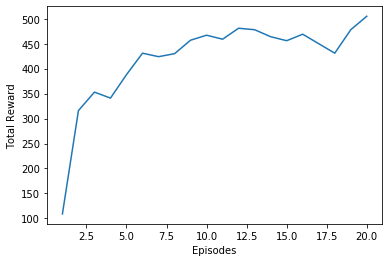

In [15]:
# Load rewards
total_reward_list = np.loadtxt( 'checkpoints/'+ symbol + '_robot_checkpoint' + str(episodes) + '_total_reward.txt')
# Plot
plt.figure()
plt.plot(np.arange(1, episodes+1), total_reward_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

In [16]:
total_reward_list

array([109., 316., 353., 341., 388., 431., 424., 430., 457., 467., 459.,
       481., 478., 464., 456., 469., 450., 431., 478., 505.])

In [17]:
def evaluate(agent, dataX, dataY, look_back):
    """
    Function run to evaluate the trained agent
    """
    
    # Length of dataset
    times = len(dataX)

    # Initial state and position
    state = dataX[:look_back, :][np.newaxis, :, :]
    pos = dataY[look_back - 1]

    # List of predicted positions
    pos_list = []
    
    done = False
    total_reward = 0
    
    for t in range(1, times - look_back + 1):

        # Predict action based on the current state
        action = agent.act(state)

        # Calculate reward
        if action == pos:   # 0:-1      1:0     2:1
            reward = +1

        elif (pos == 0 or pos == 2):
            if action == 1:
                reward = 0
            else:
                reward = -1
        else:
            reward = -1

        pos_list.append(action)
        total_reward += reward

        # Final state
        if t == times - look_back:
            done = True

        # Receive next state and position
        next_state = dataX[t:t + look_back, :][np.newaxis, :, :]
        next_pos = dataY[t + look_back - 1]

        # Remember current experience
        agent.remember(state, action, reward, next_state, done)

        # Make next_state the new current state; the same for pos
        state = next_state
        pos = next_pos

        if done:
            print('Total Reward: %i' % total_reward)

    return np.array(pos_list)

In [18]:
# Evaluate the model
# Make predictions
y_pred_test = evaluate(agent, X_test, y_test, look_back)

# Calculate and print accuracy
acc = accuracy_score(y_test[look_back-1:-1], y_pred_test)

print('Accuracy: %.2f %%' % (acc*100))

Total Reward: 104
Accuracy: 85.71 %


In [19]:
# Calculate and print precision, recall, f1 score and support
p, r, f1, s = precision_recall_fscore_support(y_test[look_back-1:-1], y_pred_test, average=None)
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

print(results.round(decimals=3))

      1-Precision  2-Recall  3-F1 score  4-Support
-1.0        0.932     0.932       0.932         59
 0.0        0.895     0.723       0.800         47
 1.0        0.721     0.912       0.805         34


In [20]:
# Decodificate labels
y_true_test = le.inverse_transform(y_test[look_back-1:-1])
y_pred_test = le.inverse_transform(y_pred_test)

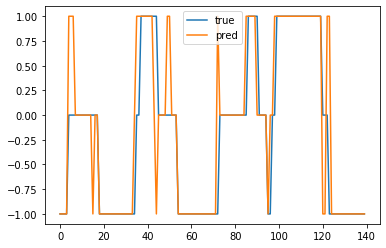

In [21]:
# Plot strategy
plt.figure()
plt.plot(y_true_test, label='true')
plt.plot(y_pred_test, label='pred')
plt.legend()
plt.show()